## CET 182 Introduction to Data Mining
Assignment

Student Name: Cheong Zihao, Daniel \
Matriculation ID: 

### Data Pre-processing

In [1]:
import os; import seaborn as sns; import pandas as pd; import numpy as np;
from ucimlrepo import fetch_ucirepo; from sklearn.preprocessing import OneHotEncoder;
import matplotlib.pyplot as plt; from sklearn.preprocessing import OrdinalEncoder;
from scipy.stats import spearmanr; import session_info
pd.options.display.max_seq_items = 150 # to show output to item length = 150
os.chdir('C:\\Users\\dc\\Desktop\\CET 182\\Project') # This is our working directory

# If url fails to connect, run this code block.
#====================================
#Use downloaded text data in 2 files (adult.data.txt and adult.test.txt).
original_train = pd.read_csv('adult.data.txt',sep=",",header=None)
original_test = pd.read_csv('adult.test.txt',sep=",",header=None)
df = pd.concat([original_train,original_test])
df = pd.read_csv('adult.data', header = None)
#url_training = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
#url_test = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

features = ['age','workclass','fnlwgt','education','education-num', 'marital-status','occupation',
           'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','target']
df.columns = features

In [2]:
# fetch dataset (Code copied from: https://archive.ics.uci.edu/dataset/2/adult)
adult = fetch_ucirepo(id=2) 
    # If 'ConnectionError' use manually downloaded 'Adult' dataset 
X = adult.data.features; y = adult.data.targets 
df = pd.DataFrame(data = X)
df['target'] = y # add the target variable
df=df.set_index(pd.Series(range(1,df.shape[0]+1)))

In [3]:
print("shape of data in (rows, columns) is " + str(df.shape)); df.tail()

shape of data in (rows, columns) is (48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
48838,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48839,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48840,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48841,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.
48842,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K.


In [4]:
print(df['target'].unique())

['<=50K' '>50K' '<=50K.' '>50K.']


In [5]:
def cleaning_target(row):
    if row == '<=50K': target = 0
    elif row == '<=50K.':target=0
    elif row == '>50K': target = 1
    else: target = 1 # row == '>50K.'
    return target
df['target'] = df['target'].apply(cleaning_target)

In [6]:
df['target'].value_counts(normalize=True).to_frame()

,target
0,0.760718
1,0.239282


In [7]:
total_null = df.isnull().sum().sum()
total_data_pts=(df.shape[0])*(df.shape[1])
if (((total_null/total_data_pts)*100) < 1):  
    df = df.dropna(axis='rows') # missing data <1%, drop the rows.
df.shape[0]

47621

##### Dealing with other Missing values: The UCI Machine Learning site mentioned 3 such variables. The metadeta description mentioned that unknown values are converted to '?'

In [8]:
rows_missing = df[ (df['workclass'] == '?') | (df['native-country'] == '?') | (df['occupation'] == '?') ]
print("Percentage of rows with '?' values :{0:f}".format(rows_missing.shape[0]/df.shape[0]*100) )

Percentage of rows with '?' values :5.037693


In [9]:
rows_missing.shape

(2399, 15)

In [10]:
# Lets drop these rows since a large number of the data (>94%) is still retained.
df=df[(df['workclass'] != '?') & (df['native-country'] != '?') & (df['occupation'] != '?')]

In [11]:
df.shape

(45222, 15)

In [12]:
# remove duplicate rows.
df.drop_duplicates(inplace=True); df.shape[0]

45175

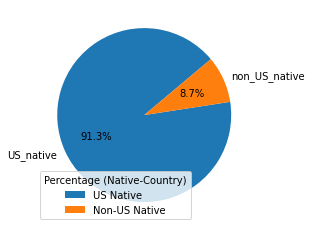

In [13]:
# Consider if 'native-country' attribute can be dropped
df['us_native'] = np.where(df['native-country'] == "United-States", 1, 0)
pie_data = df['us_native'].value_counts()/(df['us_native'].value_counts().sum())*100
plt.pie(pie_data, labels=["US_native", "non_US_native"], startangle=40, autopct='%1.1f%%')
plt.legend(title='Percentage (Native-Country)',labels=['US Native','Non-US Native'],loc='best')
plt.show()

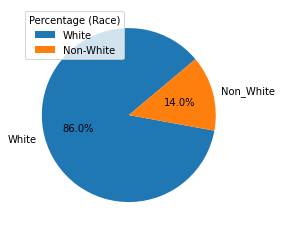

In [14]:
# Similarly, majority of race is white. 
df['white'] = np.where(df['race'] == "White", 1, 0)
pie_data2 = df['white'].value_counts()/(df['white'].value_counts().sum())*100
plt.pie(pie_data2, labels = ["White","Non_White"], startangle = 40, autopct='%1.1f%%')
plt.legend(title='Percentage (Race)',labels=['White','Non-White'],loc='best')
plt.show() #plt.savefig("race.jpg")

In [15]:
df.shape

(45175, 17)

In [16]:
# Subjects who do not work ('workclass' is without pay or never worked) should be removed from model training
# as it is not expected they will have an income.
df = df[(df['workclass'] != 'Without-pay') & (df['workclass'] != 'Never-worked')]; df.shape

(45154, 17)

In [17]:
# It is not feasible that a person works >12hrs daily (>84hrs/week)--> drop these from analysis.
df = df[df['hours-per-week'] <= 84]; df.shape

(44927, 17)

In [18]:
# 'education' can be dropped, as it is highly correlated to 'education-num'.
edu_num_array = np.array(df['education-num'])
edu_array = np.array(df['education'])
edu_enc = OrdinalEncoder(categories=[['Preschool','1st-4th','5th-6th', '7th-8th', '9th','10th', '11th','12th','HS-grad',
                                  'Some-college','Assoc-voc','Assoc-acdm','Bachelors','Masters','Prof-school','Doctorate']])
edu_encoded = edu_enc.fit_transform(edu_array.reshape(-1,1)) 
spearmanr(edu_encoded, edu_num_array)

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)

In [19]:
df = df.drop(columns=['education'])

In [20]:
# Creating dummy variables for each categorical variable
def label_encode_func(series):
    ds2=pd.DataFrame()
    ds2=pd.get_dummies(series,prefix=series.name,prefix_sep='_')
    return ds2

do=pd.DataFrame()
for i in range(df.shape[1]):
    if df[df.columns[i]].dtype =='object':
        ds1=label_encode_func(df[df.columns[i]])
        do=pd.concat([do,ds1], sort=False, axis='columns', join = 'outer')

df = pd.concat([df,do], sort=False, axis='columns', join = 'outer')

In [21]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'target',
       'us_native', 'white', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'marital-status_Divorced', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_

In [22]:
# Categorical encoding 
workclass = df[df.columns[1]].to_list()
marital_status = df[df.columns[4]].to_list()
occupation = df[df.columns[5]].to_list()
relationship = df[df.columns[6]].to_list()
sex = df[df.columns[8]].to_list()

# Workclass
wc_list = ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov']
wc_num_list = [10,21,22,31,32,33]
wc_dict = dict(zip(wc_list, wc_num_list))
wc_mapped_list = [wc_dict[v] for v in workclass if v in wc_dict]
df['workclass'] = pd.DataFrame(wc_mapped_list).values

# Marital status
ms_list = ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse']
ms_num_list = [11,20,30,12,40,13,14]
ms_dict = dict(zip(ms_list,ms_num_list))
ms_mapped_list = [ms_dict[v] for v in marital_status if v in ms_dict]
df['marital-status'] = pd.DataFrame(ms_mapped_list).values

# Occupation
occ_list = ['Tech-support','Craft-repair','Other-service','Sales','Exec-managerial','Prof-specialty','Handlers-cleaners',
            'Machine-op-inspct','Adm-clerical','Farming-fishing','Transport-moving','Priv-house-serv','Protective-serv','Armed-Forces']
occ_num_list = [1,2,99,3,4,5,6,7,8,9,10,11,12,13]
occ_dict = dict(zip(occ_list,occ_num_list))
occ_mapped_list = [occ_dict[v] for v in occupation if v in occ_dict]
df['occupation'] = pd.DataFrame(occ_mapped_list).values

# Relationship
rel_list = ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried']
rel_num_list = [1,2,3,4,5,6]
rel_dict = dict(zip(rel_list,rel_num_list))
rel_mapped_list = [rel_dict[v] for v in relationship if v in rel_dict]
df['relationship'] = pd.DataFrame(rel_mapped_list).values

# Gender
gend_list =['Female', 'Male']
gend_num_list = [1,2]
gend_dict = dict(zip(gend_list,gend_num_list))
gend_mapped_list = [gend_dict[v] for v in sex if v in gend_dict]
df['sex'] = pd.DataFrame(gend_mapped_list).values

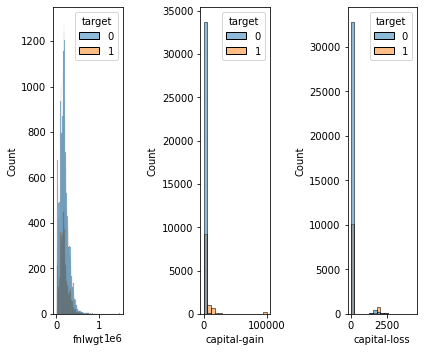

In [23]:
# Check if other numeric variables can be dropped 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(6,5))
sns.histplot(data=df, x='fnlwgt', hue='target', ax=ax1)
sns.histplot(data=df, x='capital-gain', hue='target', ax=ax2)
sns.histplot(data=df, x='capital-loss', hue='target', ax=ax3)
fig.tight_layout()
plt.show()

##### Insight - The plots of fnlwgt, capital-gain, capital-loss have a high degree of overlap (target). Predictive accuracy of the model doesn't increase by adding these variables to the model

In [24]:
# Preprocessing - Standardize 'age','hours-per-week','education-num' (mean 0, variance 1)
df=df.assign(age_scaled=lambda x:(x['age'] - x['age'].mean())/x['age'].std(),
          hpw_scaled=lambda x:(x['hours-per-week'] - x['hours-per-week'].mean())/x['hours-per-week'].std(),
          education_scaled=lambda x:(x['education-num'] - x['education-num'].mean())/x['education-num'].std())

In [25]:
print("Percentage of rows remaining from original dataset after pre-processing: {0:f}"\
      .format(df.shape[0]/len(X)*100))

Percentage of rows remaining from original dataset after pre-processing: 91.984358


In [26]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'target',
       'us_native', 'white', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'marital-status_Divorced', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_

In [27]:
df=df.reset_index()

In [28]:
df = df.drop(columns=['native-country','race'])

In [29]:
df.to_csv("df_processed_44927.csv", header=True, index=False)

### Training the model

##### The UCI ML Repository mentioned that support vector classification is among the top 5 models for baseline model performance (Best for Precision, 3rd best for Accuracy).
##### Precision score of SVC: 87.3 ~ 88.8, 
##### Accuracy score of SVC: 79.2 ~ 80.5

In [30]:
# Variable selection for Training the model
X = df.drop(columns=['index','target','age', 'workclass','marital-status','occupation', 'relationship','sex',
                     'hours-per-week', 'us_native', 'white','fnlwgt','capital-gain','capital-loss'])
y = df['target']

In [31]:
from sklearn.model_selection import train_test_split

# Split the dataset (80-20)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Classification Task - Support Vector Machine
from sklearn import svm, metrics

svc = svm.LinearSVC(C=1)
svc.fit(X_train,y_train)

# Predict the labels for the test set
y_pred = svc.predict(X_test)

C:\Users\dc\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\dc\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
# Classification Task - Support Vector Machine
from sklearn import svm, metrics
# for equal weights, remove class_weight
svc2 = svm.LinearSVC(C=1,class_weight='balanced')
svc2.fit(X_train,y_train)

# Predict the labels for the test set
y_pred2 = svc2.predict(X_test)

C:\Users\dc\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\dc\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [34]:
svc2.get_params()

{'C': 1,
 'class_weight': 'balanced',
 'dual': 'warn',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [35]:
# Model performance
#------------------
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Equal weights")
print("Accuracy:{0:.2f}, Precision:{1:.2f}, F1 Score:{2:.2f}, Recall Score:{3:.2f}"
      .format(accuracy,precision,f1_score,recall))
print("and the confusion matrix is:")
print(confusion_matrix)
accuracy2 = metrics.accuracy_score(y_test, y_pred2)
precision2 = metrics.precision_score(y_test, y_pred2)
f1_score2 = metrics.f1_score(y_test, y_pred2)
recall2 = metrics.recall_score(y_test, y_pred2)
confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)
print("Unequal weights")
print("Accuracy:{0:.2f}, Precision:{1:.2f}, F1 Score:{2:.2f}, Recall Score:{3:.2f}"
      .format(accuracy2,precision2,f1_score2,recall2))
print("and the confusion matrix is:")
print(confusion_matrix2)

Equal weights
Accuracy:0.83, Precision:0.71, F1 Score:0.62, Recall Score:0.55
and the confusion matrix is:
[[6244  490]
 [1024 1228]]
Unequal weights
Accuracy:0.77, Precision:0.53, F1 Score:0.66, Recall Score:0.88
and the confusion matrix is:
[[4959 1775]
 [ 272 1980]]


In [36]:
session_info.show()